In [6]:
# Machine learning for decision support in food energy water systems: 
# Forecasting the impact of climate change on renewable energy generation 

In [7]:
cd S:\Datasets

S:\Datasets


In [8]:
# This is the curent working copy for modelling solar power production as a function of GCM inputs

In [9]:
from pathlib import Path
from datetime import datetime
import csv
import datetime

base_path = Path.cwd().parent / 'Datasets' / 'Solar'
print(base_path)

S:\Datasets\Solar


In [10]:
# Establish hyperparameters

import pandas as pd
import numpy as np

Loss = "mean_squared_error"

Optimizer = "SGD"

Learning_Rate = 0.0000009

Batch_Size = 2048

Epochs = 60000


In [11]:
# Import training data

data_input = pd.read_csv(base_path/"Rainfall_2.csv")

In [12]:
# Constrain dataset boundaries
data_input = data_input[data_input.Daily_Average_Power != 0]

data_input = data_input[data_input.Pivot == "DPV"]

data_input = data_input[data_input.MW > 2]

data_input = data_input.dropna().reset_index(drop=True)

In [13]:
# Set convert daily average power to production factor

data_input['Daily_Average_Power'] = (data_input['Daily_Average_Power']/data_input['MW'])*100

In [14]:
%matplotlib inline
import matplotlib.pyplot as plt

# Create train / test / validation split
from sklearn.model_selection import train_test_split

train_set, test_set = train_test_split(data_input, test_size=0.2, shuffle = True, random_state = 42)
train_set, validation_set = train_test_split(train_set, test_size=0.2, shuffle = True, random_state = 42)

In [15]:
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(strategy="mean")
# Selection of inputs for training in preprocessing pipeline
data_input_num = data_input.drop(["date", 
                                  "Unnamed: 0",
                                   #"Month",
                                   #"Latitude", 
                                   #"Longitude", 
                                   "MW", 
                                   "Pivot",
                                   "Solar_Zenith_Angle",
                                   'Precipitation',
                                   "Daily_Surface_Wind_Speed", 
                                   "Daily_Mean_Temperature", 
                                   "Daily_Precipitable_Water",
                                   "Daily_Relative_Humidity",
                                   #"Min_Daily_Relative_Humidity",
                                   #"Max_Daily_Relative_Humidity",
                                   "Avg_Daily_Clearsky_GHI", 
                                   "Avg_Daily_Clearsky_DNI", 
                                   "Avg_Daily_Clearsky_DHI", 
                                   #"Avg_Daily_GHI", 
                                   "Avg_Daily_DNI", 
                                   "Avg_Daily_DHI", 
                                   "Total_Daily_Clearsky_GHI", 
                                   "Total_Daily_Clearsky_DNI", 
                                   "Total_Daily_Clearsky_DHI", 
                                   "Total_Daily_GHI", 
                                   "Total_Daily_DNI", 
                                   "Total_Daily_DHI", 
                                   "Average_Cloud_Type", 
                                   #"Daily_Minimum_Temperature", 
                                   #"Daily_Maximum_Temperature", 
                                   #"Daily_Eastward_Wind_Component", 
                                   #"Daily_Northward_Wind_Component", 
                                   "Daily_Average_Power", 
                                   "Daily_Total_Power",
                                   "Daily_Station_Up_Time",
                                   "Elevation"
                                  ], axis = 1)


imputer.fit(data_input_num)

cols = data_input_num.columns.tolist()
print(cols)

['Month', 'Latitude', 'Longitude', 'Min_Daily_Relative_Humidity', 'Max_Daily_Relative_Humidity', 'Avg_Daily_GHI', 'Daily_Minimum_Temperature', 'Daily_Maximum_Temperature', 'Daily_Eastward_Wind_Component', 'Daily_Northward_Wind_Component']


In [16]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
# Imputing and normalizing for the selected features
num_pipeline = Pipeline([
        ('imputer', SimpleImputer(strategy="mean")),('std_scaler',StandardScaler())
#        ('attribs_adder', CombinedAttributesAdder()),
    ])

In [17]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
# Pass each train, test, holdout, etc. set through the pipeline to prepare for training
num_attribs = list(data_input_num)
cat_attribs = ["Pivot"]

full_pipeline = ColumnTransformer([
        ("num", num_pipeline, num_attribs),
        ("cat", OneHotEncoder(), cat_attribs),
    ])

train_prepared = full_pipeline.fit_transform(train_set)
#test_prepared = full_pipeline.fit_transform(test_set)
#validation_prepared = full_pipeline.fit_transform(validation_set)

# When transforming the test, validation, and prediction sets we must use the scale from the training data

test_prepared = full_pipeline.transform(test_set)
validation_prepared = full_pipeline.transform(validation_set)

In [18]:
print(train_prepared[0])

[-1.32117536 -0.25373943  0.64786387 -0.99166333  0.51509448  0.43080971
 -1.13256913 -1.28957532 -0.19983761 -1.16484171  1.        ]


In [19]:
from IPython.display import clear_output
from tensorflow import keras

class PlotLearning(keras.callbacks.Callback):
    """
    Callback to plot the learning curves of the model during training.
    """
    def on_train_begin(self, logs={}):
        self.metrics = {}
        for metric in logs:
            self.metrics[metric] = []
            

    def on_epoch_end(self, epoch, logs={}):
        # Storing metrics
        for metric in logs:
            if metric in self.metrics:
                self.metrics[metric].append(logs.get(metric))
            else:
                self.metrics[metric] = [logs.get(metric)]
        
        # Plotting
        metrics = [x for x in logs if 'val' not in x]
        
        f, axs = plt.subplots(1, len(metrics), figsize=(15,5))
        clear_output(wait=True)

        for i, metric in enumerate(metrics):
            axs.plot(range(1, epoch + 2), 
                        self.metrics[metric], 
                        label=metric)
            if logs['val_' + metric]:
                axs.plot(range(1, epoch + 2), 
                            self.metrics['val_' + metric], 
                            label='val_' + metric)
                
            axs.legend()
            axs.grid()

        plt.tight_layout()
        plt.show()
        
pl = PlotLearning()

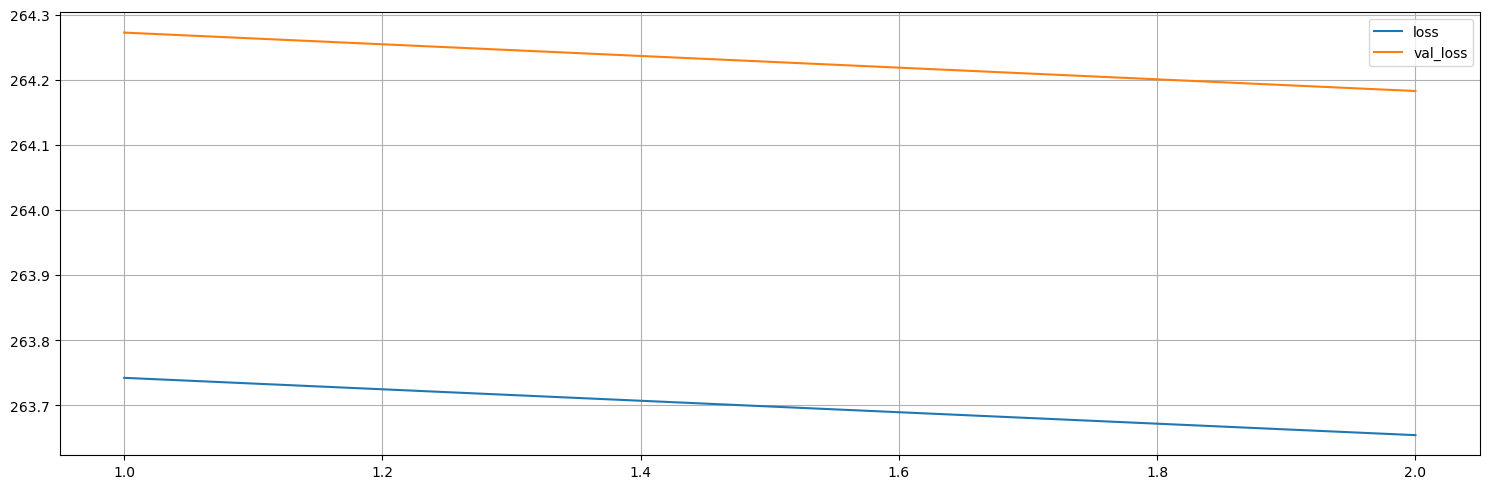

Epoch 3/60000
 86/295 [=======>......................] - ETA: 5s - loss: 263.2622

KeyboardInterrupt: 

In [20]:
import tensorflow as tf
for gpu in tf.config.experimental.list_physical_devices("GPU"):
    tf.config.experimental.set_memory_growth(gpu, True)
from tensorflow import keras
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.metrics import mean_squared_error
# Construciing our neural network
input_ = keras.layers.Input(shape=train_prepared.shape[1:])
hidden_1a = keras.layers.Dense(40, activation = "relu")(input_)
hidden_2a = keras.layers.Dense(40, activation = "relu")(hidden_1a)
hidden_3a = keras.layers.Dense(40, activation = "relu")(hidden_2a)
hidden_4a = keras.layers.Dense(40, activation = "relu")(hidden_3a)
hidden_5a = keras.layers.Dense(40, activation = "relu")(hidden_4a)
hidden_6a = keras.layers.Dense(40, activation = "relu")(hidden_5a)
hidden_7a = keras.layers.Dense(40, activation = "relu")(hidden_6a)
hidden_8a = keras.layers.Dense(40, activation = "relu")(hidden_7a)
hidden_9a = keras.layers.Dense(40, activation = "relu")(hidden_8a)
hidden_10a = keras.layers.Dense(40, activation = "relu")(hidden_9a)
hidden_11a = keras.layers.Dense(40, activation = "relu")(hidden_10a)
hidden_12a = keras.layers.Dense(40, activation = "relu")(hidden_11a)
hidden_13a = keras.layers.Dense(40, activation = "relu")(hidden_12a)
hidden_14a = keras.layers.Dense(40, activation = "relu")(hidden_13a)
hidden_15a = keras.layers.Dense(40, activation = "relu")(hidden_14a)
hidden_16a = keras.layers.Dense(40, activation = "relu")(hidden_15a)
hidden_17a = keras.layers.Dense(40, activation = "relu")(hidden_16a)
hidden_18a = keras.layers.Dense(40, activation = "relu")(hidden_17a)
hidden_19a = keras.layers.Dense(40, activation = "relu")(hidden_18a)
hidden_20a = keras.layers.Dense(40, activation = "relu")(hidden_19a)
hidden_21a = keras.layers.Dense(40, activation = "relu")(hidden_20a)
hidden_22a = keras.layers.Dense(40, activation = "relu")(hidden_21a)
hidden_23a = keras.layers.Dense(40, activation = "relu")(hidden_22a)
hidden_24a = keras.layers.Dense(40, activation = "relu")(hidden_23a)
hidden_25a = keras.layers.Dense(40, activation = "relu")(hidden_24a)
hidden_26a = keras.layers.Dense(40, activation = "relu")(hidden_25a)
hidden_27a = keras.layers.Dense(40, activation = "relu")(hidden_26a)
hidden_28a = keras.layers.Dense(40, activation = "relu")(hidden_27a)
hidden_29a = keras.layers.Dense(40, activation = "relu")(hidden_28a)
hidden_30a = keras.layers.Dense(40, activation = "relu")(hidden_29a)
hidden_31a = keras.layers.Dense(40, activation = "relu")(hidden_30a)
hidden_32a = keras.layers.Dense(40, activation = "relu")(hidden_31a)
hidden_33a = keras.layers.Dense(40, activation = "relu")(hidden_32a)
hidden_34a = keras.layers.Dense(40, activation = "relu")(hidden_33a)
hidden_35a = keras.layers.Dense(40, activation = "relu")(hidden_34a)
hidden_36a = keras.layers.Dense(40, activation = "relu")(hidden_35a)
hidden_37a = keras.layers.Dense(40, activation = "relu")(hidden_36a)
hidden_38a = keras.layers.Dense(40, activation = "relu")(hidden_37a)
hidden_39a = keras.layers.Dense(40, activation = "relu")(hidden_38a)
hidden_40a = keras.layers.Dense(40, activation = "relu")(hidden_39a)
hidden_41a = keras.layers.Dense(40, activation = "relu")(hidden_40a)
hidden_42a = keras.layers.Dense(40, activation = "relu")(hidden_41a)
hidden_43a = keras.layers.Dense(40, activation = "relu")(hidden_42a)
hidden_44a = keras.layers.Dense(40, activation = "relu")(hidden_43a)
hidden_45a = keras.layers.Dense(40, activation = "relu")(hidden_44a)
hidden_46a = keras.layers.Dense(40, activation = "relu")(hidden_45a)
hidden_47a = keras.layers.Dense(40, activation = "relu")(hidden_46a)
hidden_48a = keras.layers.Dense(40, activation = "relu")(hidden_47a)
hidden_49a = keras.layers.Dense(40, activation = "relu")(hidden_48a)
hidden_50a = keras.layers.Dense(40, activation = "relu")(hidden_49a)
hidden_51a = keras.layers.Dense(40, activation = "relu")(hidden_50a)
hidden_52a = keras.layers.Dense(40, activation = "relu")(hidden_51a)
hidden_53a = keras.layers.Dense(40, activation = "relu")(hidden_52a)
hidden_54a = keras.layers.Dense(40, activation = "relu")(hidden_53a)
hidden_55a = keras.layers.Dense(40, activation = "relu")(hidden_54a)
hidden_56a = keras.layers.Dense(40, activation = "relu")(hidden_55a)
hidden_57a = keras.layers.Dense(40, activation = "relu")(hidden_56a)
hidden_58a = keras.layers.Dense(40, activation = "relu")(hidden_57a)
hidden_59a = keras.layers.Dense(40, activation = "relu")(hidden_58a)
hidden_60a = keras.layers.Dense(40, activation = "relu")(hidden_59a)
hidden_61a = keras.layers.Dense(40, activation = "relu")(hidden_60a)
hidden_62a = keras.layers.Dense(40, activation = "relu")(hidden_61a)
hidden_63a = keras.layers.Dense(40, activation = "relu")(hidden_62a)
hidden_64a = keras.layers.Dense(40, activation = "relu")(hidden_63a)
output = keras.layers.Dense(1, activation = "relu")(hidden_64a)
NN = keras.Model(inputs = [input_], outputs = [output])

es = EarlyStopping(monitor='val_loss', 
                                min_delta= 0.001, 
                                patience= 50, 
                                verbose= 0, 
                                mode='min', 
                                baseline= None, 
                                restore_best_weights= True)

mc = ModelCheckpoint(filepath = base_path, 
                                     monitor='val_loss', 
                                     verbose= 0, 
                                     save_best_only = True,
                                     save_weights_only = False, 
                                     mode='min', 
                                     save_freq='epoch')

callbacks_list = [es, pl]

NN.compile(loss = "mean_squared_error", optimizer = keras.optimizers.Adam(learning_rate= Learning_Rate))
history = NN.fit(train_prepared, [train_set["Daily_Average_Power"]], epochs = Epochs, 
                 batch_size = Batch_Size, callbacks = callbacks_list,
                   validation_data = (validation_prepared, [validation_set["Daily_Average_Power"]]), verbose =1)

In [22]:
train_predictions = NN.predict(train_prepared)
test_predictions = NN.predict(test_prepared)

from sklearn.metrics import r2_score
Train_R2_Solar = r2_score(train_set["Daily_Average_Power"], train_predictions)
print(Train_R2_Solar)

-5.455333141350998


In [23]:
Test_R2_Solar = r2_score(test_set["Daily_Average_Power"], test_predictions)
print(Test_R2_Solar)

-5.433304007636055


In [24]:
from sklearn.metrics import mean_absolute_error
Train_MAE_Solar = mean_absolute_error(train_set["Daily_Average_Power"], train_predictions)
print(Train_MAE_Solar)

14.924823376221898


In [25]:
Test_MAE_Solar = mean_absolute_error(test_set["Daily_Average_Power"], test_predictions)
print(Test_MAE_Solar)

14.912489545193374
